# HDP-base spell-sound analyzer
# developed by Kow Kuroda (kow.kuroda@gmail.com)
# History
2024/08/19 Cython を使った cy_gen_ngrams を利用可能にした
2024/09/02 n-gram 生成の generic function を導入し，コードを簡略化
2024/09/06 term の階層クラスタリングを実装

In [1]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [2]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [3]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [4]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [5]:
## Cython を使うかどうか
use_Cython = True
if use_Cython:
    %load_ext Cython

In [6]:
## term settings
term_classes        = [ 'spell', 'sound' ]
term_class          = term_classes[0]
ngram_is_inclusive  = True
inclusion_degree    = None

## doc settings
max_doc_size        = 11
min_doc_size        =  3
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"

## term setting
term_is_skippy      = True
n_for_ngram         = 5
max_gap_ratio       = 1.0
max_gap_size        = round(max_doc_size * max_gap_ratio)
print(f"term_class: {term_class}")
print(f"term_is_skippy: {term_is_skippy}")
print(f"max_gap_size: {max_gap_size}")
print(f"n_for_ngram: {n_for_ngram}")

## symbols
gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if term_class == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")
## define term_type
if term_class == 'spell':
    if term_is_skippy:
        term_type = f"sp_skippy{n_for_ngram}gram"
    else:
        term_type = f"sp_{n_for_ngram}gram"
else:
    if term_is_skippy:
        term_type = f"sn_skippy{n_for_ngram}gram"
    else:
        term_type = f"sn_{n_for_ngram}gram"
## check
print(f"term_type: {term_type}")

max_doc_size: 11
min_doc_size: 3
term_class: spell
term_is_skippy: True
max_gap_size: 11
n_for_ngram: 5
accent_status: 
term_type: sp_skippy5gram


In [7]:
## target language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German Nouns',
                        'de_non_N_only' : 'German Non-nouns',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]
## check
target_lang_key  = target_lang_keys[11]
print(f"target_lang_key: {target_lang_key}")
print(f"target lang: {target_lang_dict[target_lang_key]} [{target_lang_key}]")

## target_attr [effective only for Irish]
target_class = ""

#target_class = None # This causes an unrediable error
if target_lang_key == "ir":
    target_classes = [ 'adjectives', 'nouns', 'verbs' ]
    target_class = f"-{target_classes[3]}"
print(f"target_class: {target_class}")

target_lang_key: es_ES
target lang: Spanish (Spain) [es_ES]
target_class: 


In [63]:
## LDA/HDP
apply_term_filtering = True
## The following parameters need to be relatively large to prevent "Row sum not equal 1" error
term_minfreq       = 2
min_bot_size       = min_doc_size # 3
abuse_threshold    = 0.05 # larger value selects shorter units, smaller value selects longer units

# number of terms listed for a given topic
n_docs_to_show     = 15
n_terms_to_show    = 20
n_terms_to_save    = 120

# saving output
save_LDAvis          = False
save_topic_structure = False

# hierarchical clustering
hc_sampling_rate = 0.01

In [9]:
## sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 5000
second_sampling          = False
second_sampling_rate     = 0.7

In [10]:
## set target files
import glob
data_dir1     = "data/open-dict-ipa/data1"
data_dir2     = "data/open-dict-ipa/data1a"
data_dir3     = "data/wn3"
data_dir4     = "data/irish"
target_files  = glob.glob(f"{data_dir1}/*")
target_files2 = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3 = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4 = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
#
target_files = sorted([ file for file in target_files if ".csv" in file ])
pp.pprint(target_files)

['data/irish/word-irish-adjectives-spell.csv',
 'data/irish/word-irish-noun-phrases-spell.csv',
 'data/irish/word-irish-nouns-spell.csv',
 'data/irish/word-irish-possessives-spell.csv',
 'data/irish/word-irish-prepositions-spell.csv',
 'data/irish/word-irish-verbs-spell.csv',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/is.csv.gz',
 'data/open-dict-ipa/data1/ja.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 '

In [11]:
## get source data from files
import pandas as pd
import gzip
#target_language_key = "en_US" # can be changed to get other languages
#if target_class != "" or target_class is not None:
if target_class != "":
    target_file = [ f for f in target_files if target_lang_key in f and target_class in f ][0]
else:
    target_file = [ f for f in target_files if target_lang_key in f ][0]
print(f"processing: {target_file}")
##
if target_lang_key == "ir":
    col_names = ['spell', 'POS']
else:
    col_names = ['spell', 'sound']

##
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

## normalize characters
raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

## modify sound
try:
    sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
    sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
    raw_df['sound'] = sounds
except (AttributeError, KeyError):
    pass
#
raw_df.sample(10)

processing: data/open-dict-ipa/data1/es_ES.csv.gz


,spell,sound
40274,alustrareis,alustɾaɾeis
233198,eclipsareis,eklipsaɾeis
546375,soltándonoslas,soˈltandonozlas
11021,acerrojó,aθeroˈxo
436486,omitiré,omitiˈɾe
67125,arriscamiento,ariskamjento
297641,escarapelar,eskaɾapelaɾ
146684,cristianizaran,kɾistjaniθaɾan
374954,inmigrareis,immiɣɾaɾeis
350961,guaiños,gwaiɲos


In [12]:
## source sampling
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		raw_df = raw_df.sample(source_sampling_max_size)
	else:
		raw_df = raw_df.sample(round(len(raw_df) * source_sampling_rate))
## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                      spell                sound
283501   #ensombreciéremos#   #ensombɾeθjeɾemos#
318276            #etrusco#            #etɾusko#
15010        #acornaríamos#       #akoɾnaɾiamos#
455716       #pintorreamos#        #pintoreamos#
594614        #zarabuteado#        #θaɾaβuteaðo#
...                     ...                  ...
322727          #exhortaba#          #eksoɾtaβa#
141160  #convalidándotelas#  #kombaliðandotelas#
401962            #magnate#            #maɣnate#
241730      #embroquelarás#       #embɾokelaɾas#
181821     #desembotáramos#     #desembotaɾamos#

[5000 rows x 2 columns]


In [13]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
283501,#ensombreciéremos#,#ensombɾeθjeɾemos#,"[#, e, n, s, o, m, b, r, e, c, i, é, r, e, m, ...",18,0,0,"[#, e, n, s, o, m, b, ɾ, e, θ, j, e, ɾ, e, m, ...",18
318276,#etrusco#,#etɾusko#,"[#, e, t, r, u, s, c, o, #]",9,0,0,"[#, e, t, ɾ, u, s, k, o, #]",9
15010,#acornaríamos#,#akoɾnaɾiamos#,"[#, a, c, o, r, n, a, r, í, a, m, o, s, #]",14,0,0,"[#, a, k, o, ɾ, n, a, ɾ, i, a, m, o, s, #]",14
455716,#pintorreamos#,#pintoreamos#,"[#, p, i, n, t, o, r, r, e, a, m, o, s, #]",14,0,0,"[#, p, i, n, t, o, r, e, a, m, o, s, #]",13
594614,#zarabuteado#,#θaɾaβuteaðo#,"[#, z, a, r, a, b, u, t, e, a, d, o, #]",13,0,0,"[#, θ, a, ɾ, a, β, u, t, e, a, ð, o, #]",13
...,...,...,...,...,...,...,...,...
322727,#exhortaba#,#eksoɾtaβa#,"[#, e, x, h, o, r, t, a, b, a, #]",11,0,0,"[#, e, k, s, o, ɾ, t, a, β, a, #]",11
141160,#convalidándotelas#,#kombaliðandotelas#,"[#, c, o, n, v, a, l, i, d, á, n, d, o, t, e, ...",19,0,0,"[#, k, o, m, b, a, l, i, ð, a, n, d, o, t, e, ...",19
401962,#magnate#,#maɣnate#,"[#, m, a, g, n, a, t, e, #]",9,0,0,"[#, m, a, ɣ, n, a, t, e, #]",9
241730,#embroquelarás#,#embɾokelaɾas#,"[#, e, m, b, r, o, q, u, e, l, a, r, á, s, #]",15,0,0,"[#, e, m, b, ɾ, o, k, e, l, a, ɾ, a, s, #]",14


In [14]:
## filtering raw_data by size
print(f"term_type: {term_type}")
if "sp_" in term_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_type: sp_skippy5gram


,spell,sound,sp_1gram,sp_size,hyphen,period,sn_1gram,sn_size
318276,#etrusco#,#etɾusko#,"[#, e, t, r, u, s, c, o, #]",9,0,0,"[#, e, t, ɾ, u, s, k, o, #]",9
444979,#pasaré#,#pasaɾe#,"[#, p, a, s, a, r, é, #]",8,0,0,"[#, p, a, s, a, ɾ, e, #]",8
74830,#atibaréis#,#atiβaɾeis#,"[#, a, t, i, b, a, r, é, i, s, #]",11,0,0,"[#, a, t, i, β, a, ɾ, e, i, s, #]",11
29956,#ahucié#,#auθje#,"[#, a, h, u, c, i, é, #]",8,0,0,"[#, a, u, θ, j, e, #]",7
234218,#eguaron#,#eɣwaɾon#,"[#, e, g, u, a, r, o, n, #]",9,0,0,"[#, e, ɣ, w, a, ɾ, o, n, #]",9
...,...,...,...,...,...,...,...,...
145899,#cremosas#,#kɾemosas#,"[#, c, r, e, m, o, s, a, s, #]",10,0,0,"[#, k, ɾ, e, m, o, s, a, s, #]",10
391625,#lastrabas#,#lastɾaβas#,"[#, l, a, s, t, r, a, b, a, s, #]",11,0,0,"[#, l, a, s, t, ɾ, a, β, a, s, #]",11
532994,#sarrosos#,#sarosos#,"[#, s, a, r, r, o, s, o, s, #]",10,0,0,"[#, s, a, r, o, s, o, s, #]",9
322727,#exhortaba#,#eksoɾtaβa#,"[#, e, x, h, o, r, t, a, b, a, #]",11,0,0,"[#, e, k, s, o, ɾ, t, a, β, a, #]",11


In [15]:
## define df after second sampling if any
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

1903

In [16]:
## generic function for n-gram generation
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}skippy{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}skippy{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

# Spell

In [17]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
318276    [#e, et, tr, ru, us, sc, co, o#, #, e, t, r, u...
444979    [#p, pa, as, sa, ar, ré, é#, #, p, a, s, a, r,...
74830     [#a, at, ti, ib, ba, ar, ré, éi, is, s#, #, a,...
29956     [#a, ah, hu, uc, ci, ié, é#, #, a, h, u, c, i,...
234218    [#e, eg, gu, ua, ar, ro, on, n#, #, e, g, u, a...
                                ...                        
145899    [#c, cr, re, em, mo, os, sa, as, s#, #, c, r, ...
391625    [#l, la, as, st, tr, ra, ab, ba, as, s#, #, l,...
532994    [#s, sa, ar, rr, ro, os, so, os, s#, #, s, a, ...
322727    [#e, ex, xh, ho, or, rt, ta, ab, ba, a#, #, e,...
401962    [#m, ma, ag, gn, na, at, te, e#, #, m, a, g, n...
Name: sp_2gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [18]:
## frequencies of 2grams
ngram_is_skippy = False
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('s#', 642),
 ('ar', 539),
 ('as', 372),
 ('#a', 320),
 ('ra', 318),
 ('es', 316),
 ('a#', 312),
 ('re', 276),
 ('en', 258),
 ('n#', 237),
 ('os', 233),
 ('#e', 230),
 ('o#', 220),
 ('ad', 219),
 ('an', 218),
 ('e#', 199),
 ('la', 192),
 ('#c', 186),
 ('er', 178),
 ('ta', 176),
 ('ca', 165),
 ('#r', 162),
 ('al', 156),
 ('te', 147),
 ('ba', 145),
 ('is', 145),
 ('se', 141),
 ('do', 138),
 ('de', 134),
 ('ea', 133)]

In [19]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
318276    [#et, etr, tru, rus, usc, sco, co#, #e, et, tr...
444979    [#pa, pas, asa, sar, aré, ré#, #p, pa, as, sa,...
74830     [#at, ati, tib, iba, bar, aré, réi, éis, is#, ...
29956     [#ah, ahu, huc, uci, cié, ié#, #a, ah, hu, uc,...
234218    [#eg, egu, gua, uar, aro, ron, on#, #e, eg, gu...
                                ...                        
145899    [#cr, cre, rem, emo, mos, osa, sas, as#, #c, c...
391625    [#la, las, ast, str, tra, rab, aba, bas, as#, ...
532994    [#sa, sar, arr, rro, ros, oso, sos, os#, #s, s...
322727    [#ex, exh, xho, hor, ort, rta, tab, aba, ba#, ...
401962    [#ma, mag, agn, gna, nat, ate, te#, #m, ma, ag...
Name: sp_3gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [20]:
## frequencies of 3grams
ngram_is_skippy = False
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('as#', 201),
 ('os#', 177),
 ('es#', 142),
 ('#en', 104),
 ('an#', 102),
 ('is#', 95),
 ('#re', 95),
 ('ara', 94),
 ('ase', 85),
 ('#de', 84),
 ('are', 82),
 ('aba', 79),
 ('en#', 77),
 ('ado', 77),
 ('mos', 73),
 ('#co', 71),
 ('ará', 71),
 ('ras', 70),
 ('do#', 69),
 ('ada', 66),
 ('#es', 65),
 ('ra#', 63),
 ('des', 57),
 ('tar', 55),
 ('res', 52),
 ('era', 51),
 ('ear', 50),
 ('ría', 48),
 ('#ca', 48),
 ('ar#', 47)]

In [21]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
318276    [#etr, etru, trus, rusc, usco, sco#, #et, etr,...
444979    [#pas, pasa, asar, saré, aré#, #pa, pas, asa, ...
74830     [#ati, atib, tiba, ibar, baré, aréi, réis, éis...
29956     [#ahu, ahuc, huci, ucié, cié#, #ah, ahu, huc, ...
234218    [#egu, egua, guar, uaro, aron, ron#, #eg, egu,...
                                ...                        
145899    [#cre, crem, remo, emos, mosa, osas, sas#, #cr...
391625    [#las, last, astr, stra, trab, raba, abas, bas...
532994    [#sar, sarr, arro, rros, roso, osos, sos#, #sa...
322727    [#exh, exho, xhor, hort, orta, rtab, taba, aba...
401962    [#mag, magn, agna, gnat, nate, ate#, #ma, mag,...
Name: sp_4gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [22]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
318276    [#etru, etrus, trusc, rusco, usco#, #etr, etru...
444979    [#pasa, pasar, asaré, saré#, #pas, pasa, asar,...
74830     [#atib, atiba, tibar, ibaré, baréi, aréis, réi...
29956     [#ahuc, ahuci, hucié, ucié#, #ahu, ahuc, huci,...
234218    [#egua, eguar, guaro, uaron, aron#, #egu, egua...
                                ...                        
145899    [#crem, cremo, remos, emosa, mosas, osas#, #cr...
391625    [#last, lastr, astra, strab, traba, rabas, aba...
532994    [#sarr, sarro, arros, rroso, rosos, osos#, #sa...
322727    [#exho, exhor, xhort, horta, ortab, rtaba, tab...
401962    [#magn, magna, agnat, gnate, nate#, #mag, magn...
Name: sp_5gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [23]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy2gram
min_size: 1
supplement_var: sp_1gram
318276    [#e, #…t, #…r, #…u, #…s, #…c, #…o, #…#, et, e…...
444979    [#p, #…a, #…s, #…a, #…r, #…é, #…#, pa, p…s, p…...
74830     [#a, #…t, #…i, #…b, #…a, #…r, #…é, #…i, #…s, #...
29956     [#a, #…h, #…u, #…c, #…i, #…é, #…#, ah, a…u, a…...
234218    [#e, #…g, #…u, #…a, #…r, #…o, #…n, #…#, eg, e…...
                                ...                        
145899    [#c, #…r, #…e, #…m, #…o, #…s, #…a, #…s, #…#, c...
391625    [#l, #…a, #…s, #…t, #…r, #…a, #…b, #…a, #…s, #...
532994    [#s, #…a, #…r, #…r, #…o, #…s, #…o, #…s, #…#, s...
322727    [#e, #…x, #…h, #…o, #…r, #…t, #…a, #…b, #…a, #...
401962    [#m, #…a, #…g, #…n, #…a, #…t, #…e, #…#, ma, m…...
Name: sp_skippy2gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [24]:
## frequencies of skippy 2grams
ngram_is_skippy = True
n_now = 2
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('a…#', 2182),
 ('#…a', 2174),
 ('#…#', 1903),
 ('e…#', 1396),
 ('r…#', 1374),
 ('#…e', 1365),
 ('#…r', 1273),
 ('a…a', 1187),
 ('#…s', 1174),
 ('#…o', 999),
 ('i…#', 871),
 ('e…a', 845),
 ('#…i', 830),
 ('#…n', 816),
 ('o…#', 816),
 ('a…e', 734),
 ('a…s', 727),
 ('l…#', 644),
 ('r…a', 643),
 ('s#', 642),
 ('s…#', 634),
 ('n…#', 599),
 ('#…l', 593),
 ('t…#', 587),
 ('c…#', 585),
 ('a…o', 568),
 ('r…s', 554),
 ('ar', 539),
 ('d…#', 525),
 ('e…s', 515)]

In [25]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy3gram
min_size: 1
supplement_var: sp_skippy2gram
318276    [#et, #e…r, #e…u, #e…s, #e…c, #e…o, #e…#, #…tr...
444979    [#pa, #p…s, #p…a, #p…r, #p…é, #p…#, #…as, #…a…...
74830     [#at, #a…i, #a…b, #a…a, #a…r, #a…é, #a…i, #a…s...
29956     [#ah, #a…u, #a…c, #a…i, #a…é, #a…#, #…hu, #…h…...
234218    [#eg, #e…u, #e…a, #e…r, #e…o, #e…n, #e…#, #…gu...
                                ...                        
145899    [#cr, #c…e, #c…m, #c…o, #c…s, #c…a, #c…s, #c…#...
391625    [#la, #l…s, #l…t, #l…r, #l…a, #l…b, #l…a, #l…s...
532994    [#sa, #s…r, #s…r, #s…o, #s…s, #s…o, #s…s, #s…#...
322727    [#ex, #e…h, #e…o, #e…r, #e…t, #e…a, #e…b, #e…a...
401962    [#ma, #m…g, #m…n, #m…a, #m…t, #m…e, #m…#, #…ag...
Name: sp_skippy3gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [26]:
## frequencies of skippy 3grams
ngram_is_skippy = True
n_now = 3
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…#', 1862),
 ('#…r…#', 1212),
 ('#…e…#', 1166),
 ('a…a…#', 878),
 ('#…a…a', 843),
 ('#…i…#', 830),
 ('#…o…#', 779),
 ('e…a…#', 650),
 ('#…s#', 642),
 ('a…s#', 595),
 ('#…l…#', 580),
 ('#…n…#', 579),
 ('#…e…a', 574),
 ('#…a…s', 570),
 ('#…a…e', 551),
 ('#…s…#', 532),
 ('#…ar', 523),
 ('a…e…#', 518),
 ('#…t…#', 508),
 ('#…r…a', 494),
 ('ar…#', 492),
 ('r…a…#', 464),
 ('#…r…s', 459),
 ('a…r…#', 442),
 ('#…i…a', 438),
 ('#…o…a', 429),
 ('#…u…#', 419),
 ('r…s#', 415),
 ('e…r…#', 408),
 ('#…d…#', 406)]

In [27]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy4gram
min_size: 1
supplement_var: sp_skippy3gram
318276    [#etr, #et…u, #et…s, #et…c, #et…o, #et…#, #e…r...
444979    [#pas, #pa…a, #pa…r, #pa…é, #pa…#, #p…sa, #p…s...
74830     [#ati, #at…b, #at…a, #at…r, #at…é, #at…i, #at…...
29956     [#ahu, #ah…c, #ah…i, #ah…é, #ah…#, #a…uc, #a…u...
234218    [#egu, #eg…a, #eg…r, #eg…o, #eg…n, #eg…#, #e…u...
                                ...                        
145899    [#cre, #cr…m, #cr…o, #cr…s, #cr…a, #cr…s, #cr…...
391625    [#las, #la…t, #la…r, #la…a, #la…b, #la…a, #la…...
532994    [#sar, #sa…r, #sa…o, #sa…s, #sa…o, #sa…s, #sa…...
322727    [#exh, #ex…o, #ex…r, #ex…t, #ex…a, #ex…b, #ex…...
401962    [#mag, #ma…n, #ma…a, #ma…t, #ma…e, #ma…#, #m…g...
Name: sp_skippy4gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [28]:
## frequencies of skippy 4grams
ngram_is_skippy = True
n_now = 4
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…a…#', 577),
 ('#…a…s#', 493),
 ('#…ar…#', 476),
 ('#…e…a…#', 418),
 ('#…r…s#', 366),
 ('#…a…e…#', 366),
 ('#…r…a…#', 339),
 ('#…o…a…#', 334),
 ('#…i…a…#', 313),
 ('#…e…s#', 309),
 ('#a…a…#', 301),
 ('#…e…r…#', 274),
 ('#…n…a…#', 272),
 ('#…a…a#', 266),
 ('#…a…o…#', 245),
 ('#…a…r…#', 237),
 ('#…u…a…#', 237),
 ('#…i…s#', 235),
 ('#e…a…#', 232),
 ('#…e…e…#', 230),
 ('#…ra…#', 230),
 ('#…s…a…#', 229),
 ('#…o…e…#', 216),
 ('#…l…a…#', 214),
 ('a…ar…#', 210),
 ('#a…r…#', 205),
 ('#…a…i…#', 201),
 ('#…as#', 201),
 ('#…l…s#', 199),
 ('#…r…e…#', 197)]

In [29]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_skippy5gram
min_size: 1
supplement_var: sp_skippy4gram
318276    [#etru, #etr…s, #etr…c, #etr…o, #etr…#, #et…us...
444979    [#pasa, #pas…r, #pas…é, #pas…#, #pa…ar, #pa…a…...
74830     [#atib, #ati…a, #ati…r, #ati…é, #ati…i, #ati…s...
29956     [#ahuc, #ahu…i, #ahu…é, #ahu…#, #ah…ci, #ah…c…...
234218    [#egua, #egu…r, #egu…o, #egu…n, #egu…#, #eg…ar...
                                ...                        
145899    [#crem, #cre…o, #cre…s, #cre…a, #cre…s, #cre…#...
391625    [#last, #las…r, #las…a, #las…b, #las…a, #las…s...
532994    [#sarr, #sar…o, #sar…s, #sar…o, #sar…s, #sar…#...
322727    [#exho, #exh…r, #exh…t, #exh…a, #exh…b, #exh…a...
401962    [#magn, #mag…a, #mag…t, #mag…e, #mag…#, #ma…na...
Name: sp_skippy5gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [30]:
## frequencies of skippy 5grams
ngram_is_skippy = True
n_now = 5
prefix = "sp_"
if ngram_is_skippy:
    skippiness = "skippy"
else:
    skippiness = "" 
var_name = f'{prefix}{skippiness}{n_now}gram'
G = [ ]
[ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_now]) for L in df[var_name] ]

import collections
collections.Counter(G).most_common(30)

[('#…a…os#', 148),
 ('#…ar…s#', 136),
 ('#…a…as#', 136),
 ('#…a…ar…#', 125),
 ('#en…a…#', 109),
 ('#…a…a…s#', 107),
 ('#…a…es#', 102),
 ('#…ar…n#', 91),
 ('#…e…ar…#', 90),
 ('#…o…ar…#', 89),
 ('#a…ar…#', 85),
 ('#…e…as#', 84),
 ('#…e…os#', 81),
 ('#…n…ar…#', 79),
 ('#…r…os#', 78),
 ('#…a…e…s#', 78),
 ('#a…a…a…#', 77),
 ('#…ar…a…#', 75),
 ('#…o…a…s#', 75),
 ('#a…a…s#', 74),
 ('#…i…ar…#', 74),
 ('#…i…as#', 74),
 ('#…a…an#', 74),
 ('#de…a…#', 74),
 ('#…r…ar…#', 72),
 ('#…r…as#', 70),
 ('#es…a…#', 69),
 ('#…a…is#', 68),
 ('#re…a…#', 68),
 ('#…a…a…a#', 67)]

In [31]:
## check result
target_vars = [ 'spell' ]
target_vars.extend([ f"sp_{i}gram" for i in range(1,6) ])
target_vars.extend([ f"sp_skippy{i}gram" for i in range(2,6) ])
df[target_vars]

,spell,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram
318276,#etrusco#,"[#, e, t, r, u, s, c, o, #]","[#e, et, tr, ru, us, sc, co, o#, #, e, t, r, u...","[#et, etr, tru, rus, usc, sco, co#, #e, et, tr...","[#etr, etru, trus, rusc, usco, sco#, #et, etr,...","[#etru, etrus, trusc, rusco, usco#, #etr, etru...","[#e, #…t, #…r, #…u, #…s, #…c, #…o, #…#, et, e…...","[#et, #e…r, #e…u, #e…s, #e…c, #e…o, #e…#, #…tr...","[#etr, #et…u, #et…s, #et…c, #et…o, #et…#, #e…r...","[#etru, #etr…s, #etr…c, #etr…o, #etr…#, #et…us..."
444979,#pasaré#,"[#, p, a, s, a, r, é, #]","[#p, pa, as, sa, ar, ré, é#, #, p, a, s, a, r,...","[#pa, pas, asa, sar, aré, ré#, #p, pa, as, sa,...","[#pas, pasa, asar, saré, aré#, #pa, pas, asa, ...","[#pasa, pasar, asaré, saré#, #pas, pasa, asar,...","[#p, #…a, #…s, #…a, #…r, #…é, #…#, pa, p…s, p…...","[#pa, #p…s, #p…a, #p…r, #p…é, #p…#, #…as, #…a…...","[#pas, #pa…a, #pa…r, #pa…é, #pa…#, #p…sa, #p…s...","[#pasa, #pas…r, #pas…é, #pas…#, #pa…ar, #pa…a…..."
74830,#atibaréis#,"[#, a, t, i, b, a, r, é, i, s, #]","[#a, at, ti, ib, ba, ar, ré, éi, is, s#, #, a,...","[#at, ati, tib, iba, bar, aré, réi, éis, is#, ...","[#ati, atib, tiba, ibar, baré, aréi, réis, éis...","[#atib, atiba, tibar, ibaré, baréi, aréis, réi...","[#a, #…t, #…i, #…b, #…a, #…r, #…é, #…i, #…s, #...","[#at, #a…i, #a…b, #a…a, #a…r, #a…é, #a…i, #a…s...","[#ati, #at…b, #at…a, #at…r, #at…é, #at…i, #at…...","[#atib, #ati…a, #ati…r, #ati…é, #ati…i, #ati…s..."
29956,#ahucié#,"[#, a, h, u, c, i, é, #]","[#a, ah, hu, uc, ci, ié, é#, #, a, h, u, c, i,...","[#ah, ahu, huc, uci, cié, ié#, #a, ah, hu, uc,...","[#ahu, ahuc, huci, ucié, cié#, #ah, ahu, huc, ...","[#ahuc, ahuci, hucié, ucié#, #ahu, ahuc, huci,...","[#a, #…h, #…u, #…c, #…i, #…é, #…#, ah, a…u, a…...","[#ah, #a…u, #a…c, #a…i, #a…é, #a…#, #…hu, #…h…...","[#ahu, #ah…c, #ah…i, #ah…é, #ah…#, #a…uc, #a…u...","[#ahuc, #ahu…i, #ahu…é, #ahu…#, #ah…ci, #ah…c…..."
234218,#eguaron#,"[#, e, g, u, a, r, o, n, #]","[#e, eg, gu, ua, ar, ro, on, n#, #, e, g, u, a...","[#eg, egu, gua, uar, aro, ron, on#, #e, eg, gu...","[#egu, egua, guar, uaro, aron, ron#, #eg, egu,...","[#egua, eguar, guaro, uaron, aron#, #egu, egua...","[#e, #…g, #…u, #…a, #…r, #…o, #…n, #…#, eg, e…...","[#eg, #e…u, #e…a, #e…r, #e…o, #e…n, #e…#, #…gu...","[#egu, #eg…a, #eg…r, #eg…o, #eg…n, #eg…#, #e…u...","[#egua, #egu…r, #egu…o, #egu…n, #egu…#, #eg…ar..."
...,...,...,...,...,...,...,...,...,...,...
145899,#cremosas#,"[#, c, r, e, m, o, s, a, s, #]","[#c, cr, re, em, mo, os, sa, as, s#, #, c, r, ...","[#cr, cre, rem, emo, mos, osa, sas, as#, #c, c...","[#cre, crem, remo, emos, mosa, osas, sas#, #cr...","[#crem, cremo, remos, emosa, mosas, osas#, #cr...","[#c, #…r, #…e, #…m, #…o, #…s, #…a, #…s, #…#, c...","[#cr, #c…e, #c…m, #c…o, #c…s, #c…a, #c…s, #c…#...","[#cre, #cr…m, #cr…o, #cr…s, #cr…a, #cr…s, #cr…...","[#crem, #cre…o, #cre…s, #cre…a, #cre…s, #cre…#..."
391625,#lastrabas#,"[#, l, a, s, t, r, a, b, a, s, #]","[#l, la, as, st, tr, ra, ab, ba, as, s#, #, l,...","[#la, las, ast, str, tra, rab, aba, bas, as#, ...","[#las, last, astr, stra, trab, raba, abas, bas...","[#last, lastr, astra, strab, traba, rabas, aba...","[#l, #…a, #…s, #…t, #…r, #…a, #…b, #…a, #…s, #...","[#la, #l…s, #l…t, #l…r, #l…a, #l…b, #l…a, #l…s...","[#las, #la…t, #la…r, #la…a, #la…b, #la…a, #la…...","[#last, #las…r, #las…a, #las…b, #las…a, #las…s..."
532994,#sarrosos#,"[#, s, a, r, r, o, s, o, s, #]","[#s, sa, ar, rr, ro, os, so, os, s#, #, s, a, ...","[#sa, sar, arr, rro, ros, oso, sos, os#, #s, s...","[#sar, sarr, arro, rros, roso, osos, sos#, #sa...","[#sarr, sarro, arros, rroso, rosos, osos#, #sa...","[#s, #…a, #…r, #…r, #…o, #…s, #…o, #…s, #…#, s...","[#sa, #s…r, #s…r, #s…o, #s…s, #s…o, #s…s, #s…#...","[#sar, #sa…r, #sa…o, #sa…s, #sa…o, #sa…s, #sa…...","[#sarr, #sar…o, #sar…s, #sar…o, #sar…s, #sar…#..."
322727,#exhortaba#,"[#, e, x, h, o, r, t, a, b, a, #]","[#e, ex, xh, ho, or, rt, ta, ab, ba, a#, #, e,...","[#ex, exh, xho, ho

# Sound

In [32]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_2gram
min_size: 1
supplement_var: sn_1gram
318276    [#e, et, tɾ, ɾu, us, sk, ko, o#, #, e, t, ɾ, u...
444979    [#p, pa, as, sa, aɾ, ɾe, e#, #, p, a, s, a, ɾ,...
74830     [#a, at, ti, iβ, βa, aɾ, ɾe, ei, is, s#, #, a,...
29956         [#a, au, uθ, θj, je, e#, #, a, u, θ, j, e, #]
234218    [#e, eɣ, ɣw, wa, aɾ, ɾo, on, n#, #, e, ɣ, w, a...
                                ...                        
145899    [#k, kɾ, ɾe, em, mo, os, sa, as, s#, #, k, ɾ, ...
391625    [#l, la, as, st, tɾ, ɾa, aβ, βa, as, s#, #, l,...
532994    [#s, sa, ar, ro, os, so, os, s#, #, s, a, r, o...
322727    [#e, ek, ks, so, oɾ, ɾt, ta, aβ, βa, a#, #, e,...
401962    [#m, ma, aɣ, ɣn, na, at, te, e#, #, m, a, ɣ, n...
Name: sn_2gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [33]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_3gram
min_size: 1
supplement_var: sn_2gram
318276    [#et, etɾ, tɾu, ɾus, usk, sko, ko#, #e, et, tɾ...
444979    [#pa, pas, asa, saɾ, aɾe, ɾe#, #p, pa, as, sa,...
74830     [#at, ati, tiβ, iβa, βaɾ, aɾe, ɾei, eis, is#, ...
29956     [#au, auθ, uθj, θje, je#, #a, au, uθ, θj, je, ...
234218    [#eɣ, eɣw, ɣwa, waɾ, aɾo, ɾon, on#, #e, eɣ, ɣw...
                                ...                        
145899    [#kɾ, kɾe, ɾem, emo, mos, osa, sas, as#, #k, k...
391625    [#la, las, ast, stɾ, tɾa, ɾaβ, aβa, βas, as#, ...
532994    [#sa, sar, aro, ros, oso, sos, os#, #s, sa, ar...
322727    [#ek, eks, kso, soɾ, oɾt, ɾta, taβ, aβa, βa#, ...
401962    [#ma, maɣ, aɣn, ɣna, nat, ate, te#, #m, ma, aɣ...
Name: sn_3gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [34]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_4gram
min_size: 1
supplement_var: sn_3gram
318276    [#etɾ, etɾu, tɾus, ɾusk, usko, sko#, #et, etɾ,...
444979    [#pas, pasa, asaɾ, saɾe, aɾe#, #pa, pas, asa, ...
74830     [#ati, atiβ, tiβa, iβaɾ, βaɾe, aɾei, ɾeis, eis...
29956     [#auθ, auθj, uθje, θje#, #au, auθ, uθj, θje, j...
234218    [#eɣw, eɣwa, ɣwaɾ, waɾo, aɾon, ɾon#, #eɣ, eɣw,...
                                ...                        
145899    [#kɾe, kɾem, ɾemo, emos, mosa, osas, sas#, #kɾ...
391625    [#las, last, astɾ, stɾa, tɾaβ, ɾaβa, aβas, βas...
532994    [#sar, saro, aros, roso, osos, sos#, #sa, sar,...
322727    [#eks, ekso, ksoɾ, soɾt, oɾta, ɾtaβ, taβa, aβa...
401962    [#maɣ, maɣn, aɣna, ɣnat, nate, ate#, #ma, maɣ,...
Name: sn_4gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [35]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_5gram
min_size: 1
supplement_var: sn_4gram
318276    [#etɾu, etɾus, tɾusk, ɾusko, usko#, #etɾ, etɾu...
444979    [#pasa, pasaɾ, asaɾe, saɾe#, #pas, pasa, asaɾ,...
74830     [#atiβ, atiβa, tiβaɾ, iβaɾe, βaɾei, aɾeis, ɾei...
29956     [#auθj, auθje, uθje#, #auθ, auθj, uθje, θje#, ...
234218    [#eɣwa, eɣwaɾ, ɣwaɾo, waɾon, aɾon#, #eɣw, eɣwa...
                                ...                        
145899    [#kɾem, kɾemo, ɾemos, emosa, mosas, osas#, #kɾ...
391625    [#last, lastɾ, astɾa, stɾaβ, tɾaβa, ɾaβas, aβa...
532994    [#saro, saros, aroso, rosos, osos#, #sar, saro...
322727    [#ekso, eksoɾ, ksoɾt, soɾta, oɾtaβ, ɾtaβa, taβ...
401962    [#maɣn, maɣna, aɣnat, ɣnate, nate#, #maɣ, maɣn...
Name: sn_5gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [36]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy2gram
min_size: 1
supplement_var: sn_1gram
318276    [#e, #…t, #…ɾ, #…u, #…s, #…k, #…o, #…#, et, e…...
444979    [#p, #…a, #…s, #…a, #…ɾ, #…e, #…#, pa, p…s, p…...
74830     [#a, #…t, #…i, #…β, #…a, #…ɾ, #…e, #…i, #…s, #...
29956     [#a, #…u, #…θ, #…j, #…e, #…#, au, a…θ, a…j, a…...
234218    [#e, #…ɣ, #…w, #…a, #…ɾ, #…o, #…n, #…#, eɣ, e…...
                                ...                        
145899    [#k, #…ɾ, #…e, #…m, #…o, #…s, #…a, #…s, #…#, k...
391625    [#l, #…a, #…s, #…t, #…ɾ, #…a, #…β, #…a, #…s, #...
532994    [#s, #…a, #…r, #…o, #…s, #…o, #…s, #…#, sa, s…...
322727    [#e, #…k, #…s, #…o, #…ɾ, #…t, #…a, #…β, #…a, #...
401962    [#m, #…a, #…ɣ, #…n, #…a, #…t, #…e, #…#, ma, m…...
Name: sn_skippy2gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [37]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy3gram
min_size: 1
supplement_var: sn_skippy2gram
318276    [#et, #e…ɾ, #e…u, #e…s, #e…k, #e…o, #e…#, #…tɾ...
444979    [#pa, #p…s, #p…a, #p…ɾ, #p…e, #p…#, #…as, #…a…...
74830     [#at, #a…i, #a…β, #a…a, #a…ɾ, #a…e, #a…i, #a…s...
29956     [#au, #a…θ, #a…j, #a…e, #a…#, #…uθ, #…u…j, #…u...
234218    [#eɣ, #e…w, #e…a, #e…ɾ, #e…o, #e…n, #e…#, #…ɣw...
                                ...                        
145899    [#kɾ, #k…e, #k…m, #k…o, #k…s, #k…a, #k…s, #k…#...
391625    [#la, #l…s, #l…t, #l…ɾ, #l…a, #l…β, #l…a, #l…s...
532994    [#sa, #s…r, #s…o, #s…s, #s…o, #s…s, #s…#, #…ar...
322727    [#ek, #e…s, #e…o, #e…ɾ, #e…t, #e…a, #e…β, #e…a...
401962    [#ma, #m…ɣ, #m…n, #m…a, #m…t, #m…e, #m…#, #…aɣ...
Name: sn_skippy3gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [38]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy4gram
min_size: 1
supplement_var: sn_skippy3gram
318276    [#etɾ, #et…u, #et…s, #et…k, #et…o, #et…#, #e…ɾ...
444979    [#pas, #pa…a, #pa…ɾ, #pa…e, #pa…#, #p…sa, #p…s...
74830     [#ati, #at…β, #at…a, #at…ɾ, #at…e, #at…i, #at…...
29956     [#auθ, #au…j, #au…e, #au…#, #a…θj, #a…θ…e, #a…...
234218    [#eɣw, #eɣ…a, #eɣ…ɾ, #eɣ…o, #eɣ…n, #eɣ…#, #e…w...
                                ...                        
145899    [#kɾe, #kɾ…m, #kɾ…o, #kɾ…s, #kɾ…a, #kɾ…s, #kɾ…...
391625    [#las, #la…t, #la…ɾ, #la…a, #la…β, #la…a, #la…...
532994    [#sar, #sa…o, #sa…s, #sa…o, #sa…s, #sa…#, #s…r...
322727    [#eks, #ek…o, #ek…ɾ, #ek…t, #ek…a, #ek…β, #ek…...
401962    [#maɣ, #ma…n, #ma…a, #ma…t, #ma…e, #ma…#, #m…ɣ...
Name: sn_skippy4gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [39]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sn_1gram
target_var: sn_skippy5gram
min_size: 1
supplement_var: sn_skippy4gram
318276    [#etɾu, #etɾ…s, #etɾ…k, #etɾ…o, #etɾ…#, #et…us...
444979    [#pasa, #pas…ɾ, #pas…e, #pas…#, #pa…aɾ, #pa…a…...
74830     [#atiβ, #ati…a, #ati…ɾ, #ati…e, #ati…i, #ati…s...
29956     [#auθj, #auθ…e, #auθ…#, #au…je, #au…j…#, #au…e...
234218    [#eɣwa, #eɣw…ɾ, #eɣw…o, #eɣw…n, #eɣw…#, #eɣ…aɾ...
                                ...                        
145899    [#kɾem, #kɾe…o, #kɾe…s, #kɾe…a, #kɾe…s, #kɾe…#...
391625    [#last, #las…ɾ, #las…a, #las…β, #las…a, #las…s...
532994    [#saro, #sar…s, #sar…o, #sar…s, #sar…#, #sa…os...
322727    [#ekso, #eks…ɾ, #eks…t, #eks…a, #eks…β, #eks…a...
401962    [#maɣn, #maɣ…a, #maɣ…t, #maɣ…e, #maɣ…#, #ma…na...
Name: sn_skippy5gram, Length: 1903, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/2203587059.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


In [40]:
## check result
dropped_vars = [ 'sp_size', 'hyphen', 'period', 'sn_size' ]
if term_class == 'spell':
    extra = [ 'sn_1gram', 'sn_2gram', 'sn_3gram', 'sn_4gram',
             'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]
else:
    extra = [ 'sp_1gram', 'sp_2gram', 'sp_3gram', 'sp_4gram',
             'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
    dropped_vars.extend(extra)
    target_vars = [ x for x in df.columns if not x in dropped_vars ]    
#
df[target_vars]

,spell,sound,sp_1gram,sp_2gram,sp_3gram,sp_4gram,sp_5gram,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram,sp_skippy5gram,sn_5gram,sn_skippy5gram
318276,#etrusco#,#etɾusko#,"[#, e, t, r, u, s, c, o, #]","[#e, et, tr, ru, us, sc, co, o#, #, e, t, r, u...","[#et, etr, tru, rus, usc, sco, co#, #e, et, tr...","[#etr, etru, trus, rusc, usco, sco#, #et, etr,...","[#etru, etrus, trusc, rusco, usco#, #etr, etru...","[#e, #…t, #…r, #…u, #…s, #…c, #…o, #…#, et, e…...","[#et, #e…r, #e…u, #e…s, #e…c, #e…o, #e…#, #…tr...","[#etr, #et…u, #et…s, #et…c, #et…o, #et…#, #e…r...","[#etru, #etr…s, #etr…c, #etr…o, #etr…#, #et…us...","[#etɾu, etɾus, tɾusk, ɾusko, usko#, #etɾ, etɾu...","[#etɾu, #etɾ…s, #etɾ…k, #etɾ…o, #etɾ…#, #et…us..."
444979,#pasaré#,#pasaɾe#,"[#, p, a, s, a, r, é, #]","[#p, pa, as, sa, ar, ré, é#, #, p, a, s, a, r,...","[#pa, pas, asa, sar, aré, ré#, #p, pa, as, sa,...","[#pas, pasa, asar, saré, aré#, #pa, pas, asa, ...","[#pasa, pasar, asaré, saré#, #pas, pasa, asar,...","[#p, #…a, #…s, #…a, #…r, #…é, #…#, pa, p…s, p…...","[#pa, #p…s, #p…a, #p…r, #p…é, #p…#, #…as, #…a…...","[#pas, #pa…a, #pa…r, #pa…é, #pa…#, #p…sa, #p…s...","[#pasa, #pas…r, #pas…é, #pas…#, #pa…ar, #pa…a…...","[#pasa, pasaɾ, asaɾe, saɾe#, #pas, pasa, asaɾ,...","[#pasa, #pas…ɾ, #pas…e, #pas…#, #pa…aɾ, #pa…a…..."
74830,#atibaréis#,#atiβaɾeis#,"[#, a, t, i, b, a, r, é, i, s, #]","[#a, at, ti, ib, ba, ar, ré, éi, is, s#, #, a,...","[#at, ati, tib, iba, bar, aré, réi, éis, is#, ...","[#ati, atib, tiba, ibar, baré, aréi, réis, éis...","[#atib, atiba, tibar, ibaré, baréi, aréis, réi...","[#a, #…t, #…i, #…b, #…a, #…r, #…é, #…i, #…s, #...","[#at, #a…i, #a…b, #a…a, #a…r, #a…é, #a…i, #a…s...","[#ati, #at…b, #at…a, #at…r, #at…é, #at…i, #at…...","[#atib, #ati…a, #ati…r, #ati…é, #ati…i, #ati…s...","[#atiβ, atiβa, tiβaɾ, iβaɾe, βaɾei, aɾeis, ɾei...","[#atiβ, #ati…a, #ati…ɾ, #ati…e, #ati…i, #ati…s..."
29956,#ahucié#,#auθje#,"[#, a, h, u, c, i, é, #]","[#a, ah, hu, uc, ci, ié, é#, #, a, h, u, c, i,...","[#ah, ahu, huc, uci, cié, ié#, #a, ah, hu, uc,...","[#ahu, ahuc, huci, ucié, cié#, #ah, ahu, huc, ...","[#ahuc, ahuci, hucié, ucié#, #ahu, ahuc, huci,...","[#a, #…h, #…u, #…c, #…i, #…é, #…#, ah, a…u, a…...","[#ah, #a…u, #a…c, #a…i, #a…é, #a…#, #…hu, #…h…...","[#ahu, #ah…c, #ah…i, #ah…é, #ah…#, #a…uc, #a…u...","[#ahuc, #ahu…i, #ahu…é, #ahu…#, #ah…ci, #ah…c…...","[#auθj, auθje, uθje#, #auθ, auθj, uθje, θje#, ...","[#auθj, #auθ…e, #auθ…#, #au…je, #au…j…#, #au…e..."
234218,#eguaron#,#eɣwaɾon#,"[#, e, g, u, a, r, o, n, #]","[#e, eg, gu, ua, ar, ro, on, n#, #, e, g, u, a...","[#eg, egu, gua, uar, aro, ron, on#, #e, eg, gu...","[#egu, egua, guar, uaro, aron, ron#, #eg, egu,...","[#egua, eguar, guaro, uaron, aron#, #egu, egua...","[#e, #…g, #…u, #…a, #…r, #…o, #…n, #…#, eg, e…...","[#eg, #e…u, #e…a, #e…r, #e…o, #e…n, #e…#, #…gu...","[#egu, #eg…a, #eg…r, #eg…o, #eg…n, #eg…#, #e…u...","[#egua, #egu…r, #egu…o, #egu…n, #egu…#, #eg…ar...","[#eɣwa, eɣwaɾ, ɣwaɾo, waɾon, aɾon#, #eɣw, eɣwa...","[#eɣwa, #eɣw…ɾ, #eɣw…o, #eɣw…n, #eɣw…#, #eɣ…aɾ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145899,#cremosas#,#kɾemosas#,"[#, c, r, e, m, o, s, a, s, #]","[#c, cr, re, em, mo, os, sa, as, s#, #, c, r, ...","[#cr, cre, rem, emo, mos, osa, sas, as#, #c, c...","[#cre, crem, remo, emos, mosa, osas, sas#, #cr...","[#crem, cremo, remos, emosa, mosas, osas#, #cr...","[#c, #…r, #…e, #…m, #…o, #…s, #…a, #…s, #…#, c...","[#cr, #c…e, #c…m, #c…o, #c…s, #c…a, #c…s, #c…#...","[#cre, #cr…m, #cr…o, #cr…s, #cr…a, #cr…s, #cr…...","[#crem, #cre…o, #cre…s, #cre…a, #cre…s, #cre…#...","[#kɾem, kɾemo, ɾemos, emosa, mosas, osas#, #kɾ...","[#kɾem, #kɾe…o, #kɾe…s, #kɾe…a, #kɾe…s, #kɾe…#..."
391625,#lastrabas#,#lastɾaβas#,"[#, l, a, s, t, r, a, b, a, s, #]","[#l, la, as, st, tr, ra, ab, ba, as, s#, #, l,...","[#la, las, ast, str, tra, rab, aba, bas, as#, ...","[#las, last, astr, stra, trab, raba, abas, bas...","[#last, lastr, astra, strab, traba, rabas, aba...","[#l, #…a, #…s, #…t, #…r, #…a, #…b, #…a, #…s, #...","[#la, #l…s

# Analysis

In [41]:
#import matplotlib
#matplotlib.font_manager.findSystemFonts(fontpaths = None, fontext = 'ttf')

In [42]:
#import HDP_utils

In [43]:
## select data type and define doc_dict
import random
if "sp_" in term_type:
    base_type = "spell"
else:
    base_type = "sound"
doc_dict = { i: x for i, x in enumerate(df[base_type]) }
## check
random.sample(doc_dict.items(), 10)

/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_63834/1181347170.py:9: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(doc_dict.items(), 10)


[(408, '#remitirá#'),
 (371, '#carnead#'),
 (1152, '#tablera#'),
 (258, '#gloriara#'),
 (1545, '#cuernos#'),
 (924, '#persista#'),
 (1060, '#carnearon#'),
 (1374, '#enraso#'),
 (1473, '#remosten#'),
 (164, '#ocasionad#')]

In [44]:
## select bots for analysis
enable_term_change = False # if you want to change term_type to save time and energy
if enable_term_change:
	term_type = 'sp_skippy4gram'
	print(f"(changed) term_type: {term_type}")

## bot stands for 'bag-of-terms', a generalization of 'bag-of-words'
bots = [ x for x in df[term_type] if len(x) > min_bot_size ] # Crucially
import random
random.sample(bots, 1)

[['#moqu',
  '#moq…i',
  '#moq…t',
  '#moq…a',
  '#moq…#',
  '#mo…ui',
  '#mo…u…t',
  '#mo…u…a',
  '#mo…u…#',
  '#mo…it',
  '#mo…i…a',
  '#mo…i…#',
  '#mo…ta',
  '#mo…t…#',
  '#mo…a#',
  '#m…qui',
  '#m…qu…t',
  '#m…qu…a',
  '#m…qu…#',
  '#m…q…it',
  '#m…q…i…a',
  '#m…q…i…#',
  '#m…q…ta',
  '#m…q…t…#',
  '#m…q…a#',
  '#m…uit',
  '#m…ui…a',
  '#m…ui…#',
  '#m…u…ta',
  '#m…u…t…#',
  '#m…u…a#',
  '#m…ita',
  '#m…it…#',
  '#m…i…a#',
  '#m…ta#',
  '#…oqui',
  '#…oqu…t',
  '#…oqu…a',
  '#…oqu…#',
  '#…oq…it',
  '#…oq…i…a',
  '#…oq…i…#',
  '#…oq…ta',
  '#…oq…t…#',
  '#…oq…a#',
  '#…o…uit',
  '#…o…ui…a',
  '#…o…ui…#',
  '#…o…u…ta',
  '#…o…u…t…#',
  '#…o…u…a#',
  '#…o…ita',
  '#…o…it…#',
  '#…o…i…a#',
  '#…o…ta#',
  '#…quit',
  '#…qui…a',
  '#…qui…#',
  '#…qu…ta',
  '#…qu…t…#',
  '#…qu…a#',
  '#…q…ita',
  '#…q…it…#',
  '#…q…i…a#',
  '#…q…ta#',
  '#…uita',
  '#…uit…#',
  '#…ui…a#',
  '#…u…ta#',
  '#…ita#',
  'moqui',
  'moqu…t',
  'moqu…a',
  'moqu…#',
  'moq…it',
  'moq…i…a',
  'moq…i…#',
  'mo

In [45]:
## generate dictionary
from gensim.corpora import Dictionary
diction = Dictionary(bots)
print(diction)

#apply_term_filtering = False
if apply_term_filtering:
    print(f"term filtering applied")
    diction.filter_extremes(no_below = term_minfreq, no_above = abuse_threshold)
else:
    print(f"term filtering not applied")
## check
print(diction)
## generate DTM
corpus = [ diction.doc2bow(bot) for bot in bots if len(bot) >= min_bot_size ] # Crucially

Dictionary<474948 unique tokens: ['#', '#e', '#et', '#etr', '#etru']...>
term filtering applied
Dictionary<100000 unique tokens: ['#et', '#etr', '#etru', '#etr…#', '#etr…c']...>


In [46]:
## sanitize corpus: HDP の場合は必須の処理
corpus = [ doc for doc in corpus if len(doc) > 0 ] # filter out empty rows 

In [47]:
## HDP (n_topics = 15)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 15
hdp15 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data15 = pyLDAvis.gensim.prepare(hdp15, corpus, diction)
pyLDAvis.display(vis_data15)

In [48]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data15, vis_output)

In [49]:
## import helper functions
import numpy as np
import HDP_helper
reload_module = True
if reload_module:
    import importlib
    importlib.reload(HDP_helper)

In [50]:
## topic investigation
target_hdp = hdp15
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * ra…a + 0.0 * a…ad + 0.0 * #…ra…a + 0.0 * #a…a…a + 0.0 * a…ad…# + 0.0 * ra…a…# + 0.0 * a…es# + 0.0 * a…a…o# + 0.0 * g…a…# + 0.0 * g…e + 0.0 * a…á + 0.0 * #…a…es + 0.0 * #…b…a…# + 0.0 * g…s + 0.0 * a…a…a# + 0.0 * i…d + 0.0 * #…b…a + 0.0 * #…b…s + 0.0 * #…i…d + 0.0 * #…a…ea
nonzero count:  499
	0.9989: #barateado#
	0.9987: #atracases#
	0.9987: #raqueadas#
	0.9987: #alunarada#
	0.9987: #asediaste#
	0.9987: #barateará#
	0.9986: #adinerara#
	0.9986: #taraceado#
	0.9986: #airándote#
	0.9986: #abaratará#
	0.9986: #adentraré#
	0.9986: #abarcadas#
	0.9986: #grietases#
	0.9986: #aseábamos#
	0.9985: #lastrabas#
topic_id 1: 0.0 * e…a…e + 0.0 * a…á + 0.0 * e…r…s# + 0.0 * #en…a + 0.0 * #en…a…# + 0.0 * e…r…a + 0.0 * n…ar + 0.0 * a…es# + 0.0 * #…a…a…s# + 0.0 * e…a…s# + 0.0 * en…r…# + 0.0 * n…ar…# + 0.0 * e…ra…# + 0.0 * #e…e + 0.0 * c…r…a + 0.0 * #…a…á + 0.0 * en…r + 0.0 * rá + 0.0 * #…rá + 0.0 * #e…a…e
nonzero count:  430
	0.9989: #acantares#
	0.9989: #aferrarás#
	0.9988: #aventaras#


In [51]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp15.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp15_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp15_topics_out, header = False, index = None)
    print(f"saved: {hdp15_topics_out}")

11107 rows remain after density filtering, discarding 88893 rows
10640 rows remain after size filtering, discarding 467 rows
106 rows remain after size filtering, discarding 10534 rows


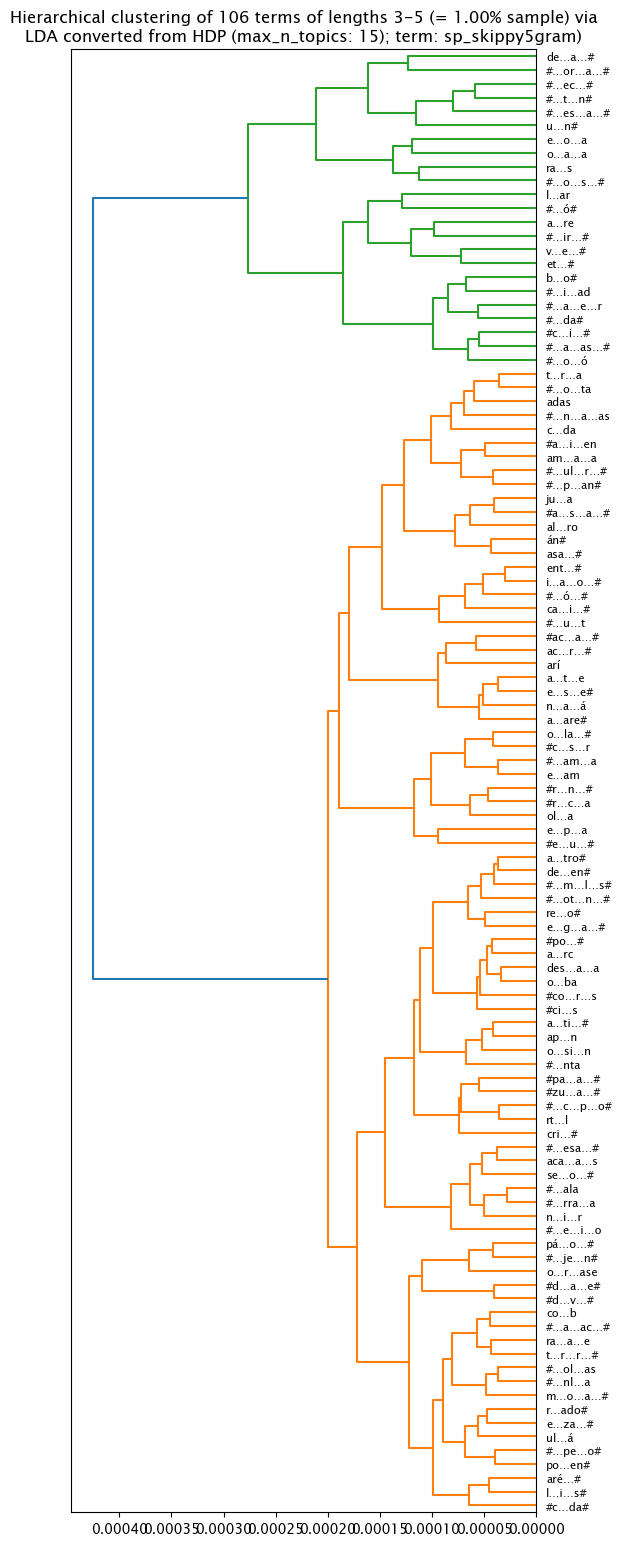

In [52]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp15, diction, term_type = term_type, n_topics= 15, lowest_density = 0.0002, max_length = n_for_ngram, min_length = 3, sampling_rate = hc_sampling_rate, gap_mark = gap_mark, use_CJK = False, check = False)

In [53]:
## HDP (n_topics = 45)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 45
hdp45 = gensim.models.HdpModel(corpus, diction, T = max_n_topics, random_state = 1)
vis_data45 = pyLDAvis.gensim.prepare(hdp45, corpus, diction)
pyLDAvis.display(vis_data45)

In [54]:
## save LDAvis output as a html file
lang_dir_name = target_lang_dict[target_lang_key].split()[0]
#save_LDAvis = True
if save_LDAvis:
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data45, vis_output)

In [55]:
## save topic structures
if save_topic_structure:
    #hdp.get_topics() # =/= show_topics()
    #hdp.print_topics()
    hdp_topics = hdp45.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }
    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    #hdp45_topics_out = f"results/terms-by-topics-raw/hdp{max_n_topics}_topics_raw.csv"
    hdp45_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp45_topics_out, header = False, index = None)
    print(f"saved: {hdp45_topics_out}")

In [56]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp45
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob
#
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: {len(probs.nonzero()[0])}")
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * a…á + 0.0 * #en…a + 0.0 * #en…a…# + 0.0 * #…a…á + 0.0 * e…a…e + 0.0 * r…l + 0.0 * #e…a…a + 0.0 * #a…a…a + 0.0 * a…ad + 0.0 * a…es# + 0.0 * #…l…e…# + 0.0 * #…r…d + 0.0 * r…l…# + 0.0 * e…o# + 0.0 * e…r…a + 0.0 * rá + 0.0 * #…rá + 0.0 * #…l…n + 0.0 * i…ar + 0.0 * e…a…s#
nonzero count: 911
	0.9992: #encasaras#
	0.9992: #envirares#
	0.9992: #alunarada#
	0.9992: #envidarás#
	0.9992: #acampadas#
	0.9991: #elucidará#
	0.9991: #resbalare#
	0.9991: #apiadarán#
	0.9991: #abarcadas#
	0.9991: #enlaminas#
	0.9991: #amamantan#
	0.9991: #encobilan#
	0.9991: #abrasarla#
	0.9991: #lastrabas#
	0.9991: #enrollare#
topic_id 1: 0.0 * is# + 0.0 * #…is# + 0.0 * #d…s + 0.0 * a…is + 0.0 * a…is# + 0.0 * d…s…# + 0.0 * r…is# + 0.0 * #…a…is + 0.0 * #…a…is# + 0.0 * #…r…is# + 0.0 * r…is + 0.0 * #…r…is + 0.0 * #d…s…# + 0.0 * #…s…e…# + 0.0 * #…a…a…s# + 0.0 * o…r…s + 0.0 * #…o…r…s + 0.0 * #…se…# + 0.0 * e…is + 0.0 * #…r…se
nonzero count: 200
	0.9987: #borrajees#
	0.9986: #porreasen#
	0.9986: #postrasen

6815 rows remain after density filtering, discarding 93185 rows
6811 rows remain after size filtering, discarding 4 rows
68 rows remain after size filtering, discarding 6743 rows


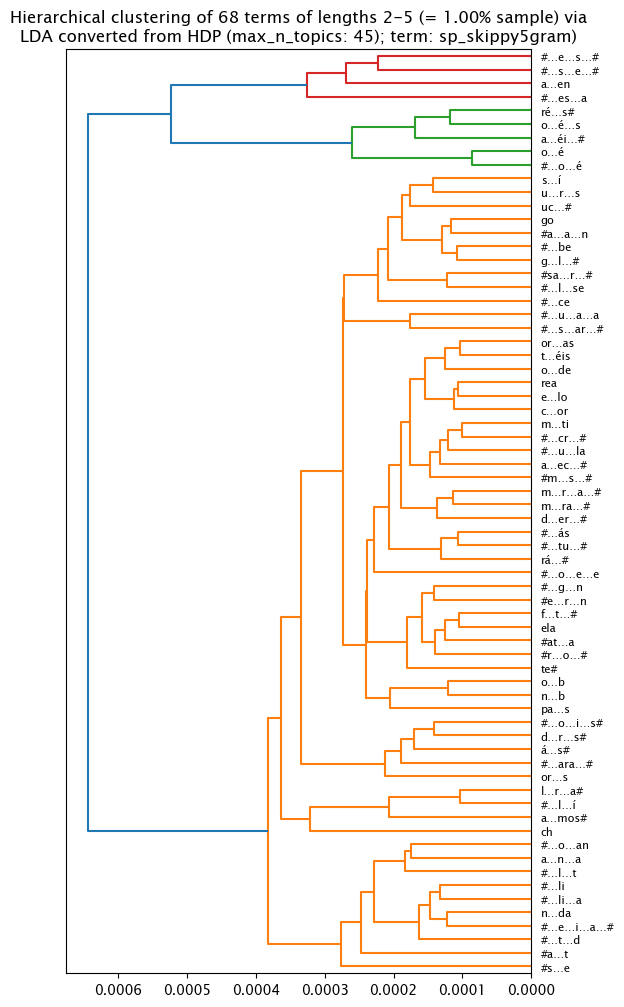

In [57]:
## term の階層クラスタリング: max_n_topics の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp (hdp45, diction, term_type = term_type, n_topics = 45, lowest_density = 0.0006, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = hc_sampling_rate, check = False)

In [58]:
## HDP (n_topics = 90)
import gensim.models
import pyLDAvis.gensim

max_n_topics = 90
hdp90 = gensim.models.HdpModel(corpus, diction, T = max_n_topics,
                               random_state = 1)
vis_data90 = pyLDAvis.gensim.prepare(hdp90, corpus, diction)
pyLDAvis.display(vis_data90)

In [59]:
## save LDAvis output as a html file
#save_LDAvis = True
if save_LDAvis:
	lang_dir_name = target_lang_dict[target_lang_key].split()[0]
	vis_output = f"results/LDAvis/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-HDP-max_ntop{max_n_topics}-{term_type}{accent_status}.html"
	pyLDAvis.save_html(vis_data90, vis_output)

In [60]:
## save topic structures
if save_topic_structure:
    hdp_topics = hdp90.show_topics(num_topics = max_n_topics,
                                num_words = n_terms_to_save, formatted = False)
    hdp_dict = { tid: values for tid, values in hdp_topics }

    ## convert to Pandas dataframe
    topics_df = pd.DataFrame.from_dict(hdp_dict)
    hdp90_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
    topics_df.to_csv(hdp90_topics_out, header = False, index = None)
    print(f"saved: {hdp90_topics_out}")

In [61]:
## topic investigation
import numpy as np
import HDP_helper

target_hdp = hdp90
documents_topics = np.zeros([target_hdp.m_T, len(corpus)])
for doc_id, c in enumerate(corpus):
    for topic_id, prob in target_hdp[c]:
        documents_topics[topic_id][doc_id] = prob

## investigate topics
target_hdp.optimal_ordering()
for topic_id, probs in enumerate(documents_topics):
    print(f"==============")
    #topic_encoding = ", ".join(hdp.show_topic(topic_id))
    topic_t = target_hdp.print_topic(topic_id, topn = n_terms_to_show)
    print(f"topic_id {topic_id}: {HDP_helper.reformat_topic (topic_t, n_terms_to_show)}")
    print(f"nonzero count: ", len(probs.nonzero()[0]))
    for doc_id in probs.argsort()[::-1][:n_docs_to_show]:
        doc = doc_dict[doc_id]
        print(f"\t{probs[doc_id]:0.4f}: {doc}")

topic_id 0: 0.0 * a…á + 0.0 * #a…a…a + 0.0 * #…a…á + 0.0 * #a…ar + 0.0 * ar…n# + 0.0 * #…ar…n# + 0.0 * b…r…# + 0.0 * al…a + 0.0 * #a…ar…# + 0.0 * #a…a…a…# + 0.0 * a…c…# + 0.0 * a…c + 0.0 * ra…a + 0.0 * l…ar + 0.0 * a…á# + 0.0 * rá + 0.0 * #…rá + 0.0 * #…ra…a + 0.0 * al…a…# + 0.0 * l…ar…#
nonzero count:  283
	0.9987: #masacrará#
	0.9987: #atracases#
	0.9987: #barretean#
	0.9987: #alunarada#
	0.9986: #anegarían#
	0.9986: #abaratará#
	0.9986: #amamantan#
	0.9986: #abarcaran#
	0.9985: #solidarán#
	0.9985: #abrasarla#
	0.9985: #lastrabas#
	0.9985: #jalearías#
	0.9985: #barbeasen#
	0.9985: #madrinero#
	0.9985: #atraerían#
topic_id 1: 0.001 * #p…a + 0.0 * ca…a + 0.0 * #p…a…# + 0.0 * #e…e + 0.0 * ca…a…# + 0.0 * #p…e + 0.0 * #p…r + 0.0 * #…a…ra + 0.0 * #p…e…# + 0.0 * #es…a + 0.0 * #…ca…a + 0.0 * e…o…a + 0.0 * #e…e…# + 0.0 * es…r + 0.0 * #…d…r + 0.0 * c…as + 0.0 * p…o…# + 0.0 * #p…r…# + 0.0 * #…s…e…# + 0.0 * #es…a…#
nonzero count:  98
	0.9987: #picaneara#
	0.9986: #creadoras#
	0.9986: #caladoras

7189 rows remain after density filtering, discarding 92811 rows
7185 rows remain after size filtering, discarding 4 rows
72 rows remain after size filtering, discarding 7113 rows


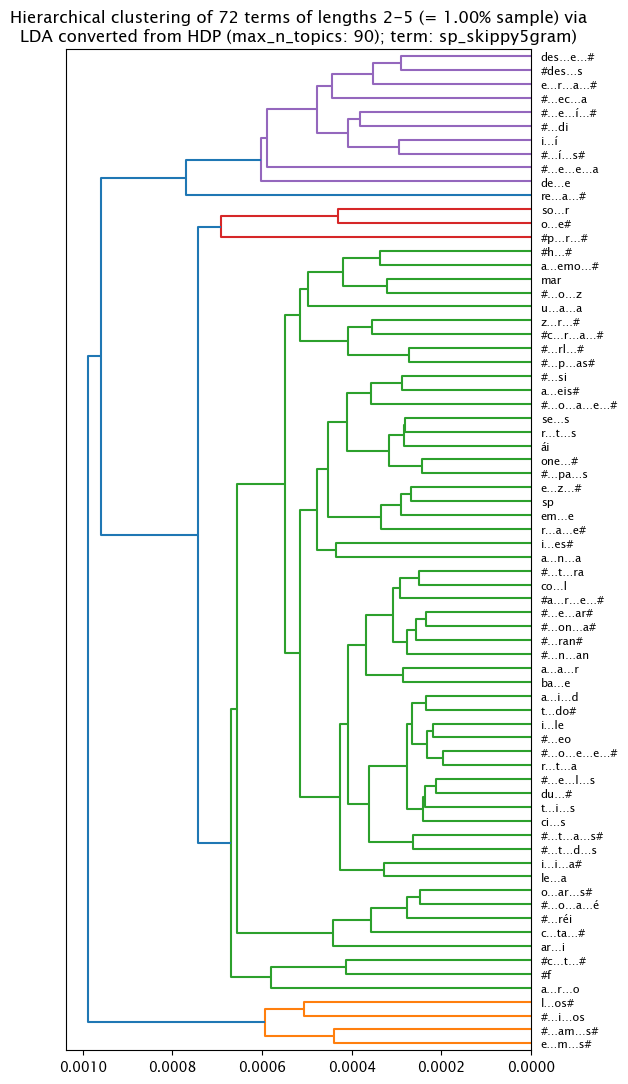

In [62]:
## term の階層クラスタリング: max_n_topics, term の値に拠ってparameters の最適値は異なる
HDP_helper.hc_clustering_terms_from_hdp(hdp90, diction, term_type = term_type, n_topics = 90, lowest_density = 0.0012, max_length = n_for_ngram, min_length = 2, gap_mark = gap_mark, sampling_rate = hc_sampling_rate, check = False)